In [1]:
try:
  # This command only in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [2]:
# Get project files
!wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip

!unzip cats_and_dogs.zip

PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])#2001
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])#1001
total_test = len(os.listdir(test_dir))#51

# Variables for pre-processing and training.
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

Streaming output truncated to the last 5000 lines.
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.657.jpg  
  inflating: cats_and_dogs/train/dogs/dog.131.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.131.jpg  
  inflating: cats_and_dogs/train/dogs/dog.119.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.119.jpg  
  inflating: cats_and_dogs/train/dogs/dog.74.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.74.jpg  
  inflating: cats_and_dogs/train/dogs/dog.60.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.60.jpg  
  inflating: cats_and_dogs/train/dogs/dog.858.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.858.jpg  
  inflating: cats_and_dogs/train/dogs/dog.680.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.680.jpg  
  inflating: cats_and_dogs/train/dogs/dog.694.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.694.jpg  
  inflating: cats_and_dogs/train/dogs/dog.864.jpg  
  inflating: __MACOSX/cats_and_do

In [3]:
# 3
train_image_generator = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255)
test_image_generator = ImageDataGenerator(rescale=1./255)


train_data_gen = train_image_generator.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
val_data_gen = validation_image_generator.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
test_data_gen = test_image_generator.flow_from_directory(
        PATH,
        target_size=(150, 150),
        batch_size=batch_size,
        classes=['test'],
        shuffle=False)


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.


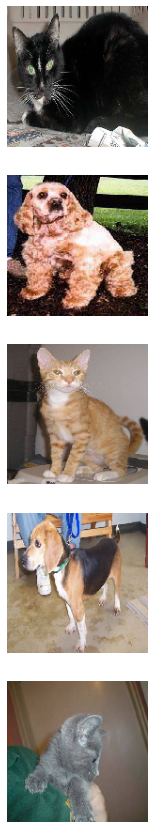

In [4]:
# 4
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])


In [5]:
# 5
train_image_generator = ImageDataGenerator(rescale=1./255, horizontal_flip=True,zoom_range=0.2, vertical_flip=True,rotation_range=45)



Found 2000 images belonging to 2 classes.


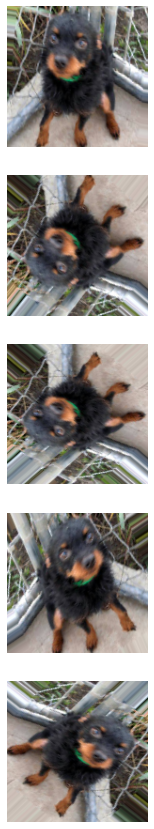

In [6]:
# 6
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

plotImages(augmented_images)

In [7]:
# 7
model = Sequential()
model.add(Conv2D(32, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu', input_shape=(150,150,3)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64, kernel_size=(3,3), strides=(1,1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(128, kernel_size=(3,3), strides=(1,1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(2, activation='linear'))
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'], optimizer='adam')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 73, 73, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

In [8]:
# 8
history = model.fit(x=train_data_gen,
                    steps_per_epoch = total_train//batch_size,
                    epochs=epochs, 
                    validation_data=(val_data_gen)
                    )

Epoch 1/15
15/15 [==============================] - 22s 1s/step - loss: 0.8107 - accuracy: 0.5069 - val_loss: 0.6920 - val_accuracy: 0.5000
Epoch 2/15
15/15 [==============================] - 19s 1s/step - loss: 0.6928 - accuracy: 0.5010 - val_loss: 0.6900 - val_accuracy: 0.5010
Epoch 3/15
15/15 [==============================] - 17s 1s/step - loss: 0.6901 - accuracy: 0.5182 - val_loss: 0.6860 - val_accuracy: 0.5500
Epoch 4/15
15/15 [==============================] - 19s 1s/step - loss: 0.6901 - accuracy: 0.5481 - val_loss: 0.6899 - val_accuracy: 0.5380
Epoch 5/15
15/15 [==============================] - 17s 1s/step - loss: 0.6883 - accuracy: 0.5422 - val_loss: 0.6812 - val_accuracy: 0.5090
Epoch 6/15
15/15 [==============================] - 17s 1s/step - loss: 0.6855 - accuracy: 0.5475 - val_loss: 0.6740 - val_accuracy: 0.5320
Epoch 7/15
15/15 [==============================] - 17s 1s/step - loss: 0.6756 - accuracy: 0.5785 - val_loss: 0.6749 - val_accuracy: 0.5670
Epoch 8/15
15/15 [==

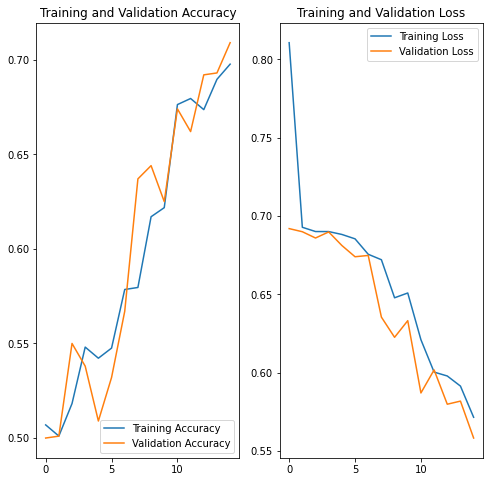

In [9]:
# 9
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
test_data_gen[0][0]

1/1 [==============================] - 1s 519ms/step


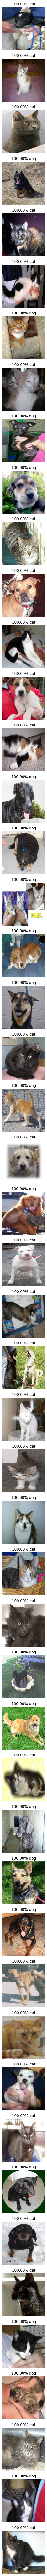

In [11]:
probabilities = np.argmax(model.predict(test_data_gen), axis=-1)
plotImages(test_data_gen[0][0], probabilities=probabilities)

In [12]:
# 11
answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 
            0, 0, 0, 0, 0, 0]

correct = 0

for probability, answer in zip(probabilities, answers):
  if round(probability) == answer:
    correct +=1

percentage_identified = (correct / len(answers)) * 100

passed_challenge = percentage_identified >= 63

print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")

if passed_challenge:
  print("You passed the challenge!")
else:
  print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")

Your model correctly identified 66.0% of the images of cats and dogs.
You passed the challenge!
